In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz as gr
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, PoissonRegressor, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from causalml.inference.meta import BaseXRegressor

from econml.grf import CausalIVForest

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Abstract

In this post, we provide an implementation for the paper *Uplift Modeling for Multiple Treatments with Cost
Optimization* [@zhao2019uplift]. We provide this implementation in the context of a marketing department testing which marketing campaign is most effective for a given loyalty tier. We continue with this example by extending the uplift framework to non-compliance situations. In this, we demonstrate the effectiveness of Causal Forests [@wager2015estimation] in calculating conditional local average treatment effects (C-LATE). The full code for this implementation can be found at the [github repo.](https://github.com/thebayesianbandit/thebayesianbandit.github.io/blob/main/posts/uplift_paper/uplift_paper.ipynb)

# Introduction

Uplift modeling is a useful way of measuring the incremental impact of treatments compared to the control. Essentially, it measures *how* an individual will react to interventions. @eq-uplift-1 shows the math behind the calculation.

$$
\text{Uplift}_i = Y_i(1) - Y_i(0)
$${#eq-uplift-1}

@eq-uplift-1 utilizes the potential outcomes framework derived by Rubin in [@rubin1974estimating]. Since we can only ever observe the effects of treatment or control on an individual, the average treatment effect (ATE) @eq-uplift-2 is the usual metric calculated to understand treatment impact in an experiment. Furthermore, to understand how the treatment effect changes amongst subgroups/subpopulations, the conditional average treatment effect (CATE) @eq-uplift-3 is useful in identifying the heterogeneous treatment effect. 

$$
\tau = E[Y_i(1) - Y_i(0)]
$${#eq-uplift-2}

$$
\tau(x_i) = E[Y_i(1) - Y_i(0) | X]
$${#eq-uplift-3}

In the context of marketing, the CATE is of great interest since it helps marketing organizations identify how treatments fair with different customer segments. For example, a marketing team might run a A/B test with some customers receiving a special promo (treatment) while others receive nothing (control) to see if there is a change in purchase behavior. 

Uplift modeling follows the same basic assumptions of most causal inference models, namely: stable unit treatment value assumption (SUTVA), unconfoundness, and overlap. SUTVA means that there is no interference between treatment assignments and potential outcomes of individuals, as well as no unaccounted treatment versions in the study. Unconfoundness means the treatment assignment is independent of potential outcomes after conditioning on observed covariates (X) (see @eq-uncon-1). Overlap means that for every observed combination of covariates (X) in the data, there is a non-zero probability of being assigned to either treatment or control. 

$$
\{Y(1), Y(0)\} \perp T \mid X
$${#eq-uncon-1}

# Problem Formulation

We pose the situation of a bakery business looking to increase ticket sizes via promotional campaigns. The bakery business is fairly simple with the following price-cost structure (see @tbl-biz).

| Items   | Price | Cost |
|:--------|:------|:-----|
| Donut   | \$2.50 | \$1.00 |
| Pastry  | \$3.00 | \$1.50 |
| Sandwich| \$4.50 | \$2.00 |
| Coffee  | \$1.00 | \$0.20 |
| Juice   | \$1.50 | \$0.50 |

: Bakery Price-Cost Structure {#tbl-biz}

Currently, the business runs a loyalty program that is four-tiered with levels: none, bronze, silver, gold. Each tier repeats purchases at a different rate (from the synthetic data, this is defined as a Poisson r.v.). Furthermore, customers are not willing to go and purchase things from our bakery if they are too far away. We define the distance from the bakery as the time when promotions are sent out to customers (for those who receive no promotions, it is still marked at the same time as promotion receivers). Lastly, we assume that the company's promotions have an effect on the ticket size of an individual transaction. @fig-dag-1 illustrates our assumed flow of causality for this situation. 

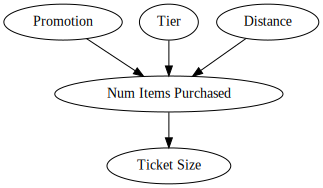

In [2]:
#| label: fig-dag-1
#| fig-cap: "Proposed DAG for our experiment on increasing individual transaction ticket size."

#Show DAG
g = gr.Digraph()
g.edge("Promotion", "Num Items Purchased")
g.edge("Tier", "Num Items Purchased")
g.edge("Distance", "Num Items Purchased")
g.edge("Num Items Purchased", "Ticket Size")

g

While @fig-dag-1 shows the flow of causality going through the number of items purchased to determine ticket size, we will focus our analysis and modeling on the ticket size and will ignore this step of the DAG. This is to more easily calculate *Net Value* of the transaction, where we will define this as $NV = R - MC$, where $NV$ is net value, $R$ is revenue, and $MC$ is marketing costs. From this, we propose that the optimal treatment program (i.e. optimal policy) can be defined in @eq-opt-1.

$$\pi^* \in \underset{\pi}{\operatorname{argmax}} \{V(\pi)\} , \quad \pi^*(x) = \mathbf{1} (\{\tau(x) > 0\})$${#eq-opt-1}

@eq-opt-1 states that the optimal policy $\pi$ is that which maximizes the some arbitrary value function $V(\pi)$. Although the above question is generally for single treatment experiments, it can be extended to multiple treatments.

Specifically, the business wants to experiment with 3 different treatments: free donut, free juice, and a 30% discount. Furthermore, they wish to know through which marketing channel is the treatment most effective, namely: social media, in-app notifications, and email. Therefore, we have 9 distinct treatments that we need to test against the control (i.e. receiving no promotion). 

**Assummptions**: We list here some crucial assumptions for this analysis demonstration. First, we operate under the 3 assumptions stated above (SUTVA, unconfoundness, and overlap). Second, we operate under the assumption that there is no spill over effect amongst participants. Though this is not an exhaustive list of assumptions from this experiment, these are sufficient for the educational purposes of this post.

In [3]:
#Generate synthetic dataset
def get_purchase_size(tier, item_dict, treat, channel='none', distance=0):
    distance_thresh = 2.7
    
    num_items_dict = {
        'none': np.random.poisson(.5),
        'bronze': np.random.poisson(1),
        'silver': np.random.poisson(2),
        'gold': np.random.poisson(4)
    }
    
    treat_item_dict = {
        'none': {'social': {'free_donut': 0, 'discount': 1, 'free_juice': 0}, 
                 'in-app': {'free_donut': 0, 'discount': 0, 'free_juice': 0},
                 'email': {'free_donut': 0, 'discount': 0, 'free_juice': 0}
                },
        
        'bronze': {'social': {'free_donut': 0, 'discount': 0, 'free_juice': 0}, 
                   'in-app': {'free_donut': 2, 'discount': 1, 'free_juice': 1},
                   'email': {'free_donut': 0, 'discount': 0, 'free_juice': 0}
                  },
        
        'silver': {'social': {'free_donut': 0, 'discount': 0, 'free_juice': 0}, 
                   'in-app': {'free_donut': 2, 'discount': 2, 'free_juice': 2},
                   'email': {'free_donut': 0, 'discount': 0, 'free_juice': 0}
                  },
        
        'gold': {'social': {'free_donut': 0, 'discount': 0, 'free_juice': 0}, 
                 'in-app': {'free_donut': 1, 'discount': 0, 'free_juice': 0},
                 'email': {'free_donut': 0, 'discount': 0, 'free_juice': 0}
                },
    }
    
    if distance > distance_thresh:
        return 0, 0
    else:
        if treat == 'none':
            avg_items = num_items_dict[tier]
            
        else:
            avg_items = num_items_dict[tier] + treat_item_dict[tier][channel][treat]
            
        items = np.random.choice(list(item_dict.keys()), p=[.4, .2, .1, .2, .1], size=avg_items)
        total = sum(item_dict[i] for i in items)
    
    
    return total, len(items)

def get_syn_data(n_users, n_days, r_seed):
    np.random.seed(r_seed)
    
    items_price_dict = {
        'donut': 2.50,
        'pastry': 3.00,
        'sandwich': 4.50,
        'coffee': 1.00,
        'juice': 1.50
    }
    
    var_cost_dict = {
        'social': .1,
        'in-app': .02,
        'email': .05
    }
    
    treatments_cost_dict = {
        'free_donut': 1,
        'discount': .3,
        'free_juice': .5,
    }
    
    purchase_data_dict = {
        'user_id': [],
        'age': [],
        'loyalty_tier': [],
        'distance_store': [],
        'ticket_size': [],
        'num_items_purchased': [],
        'marketing_channel': [],
        'marketing_treatment': [],
        'marketing_costs': []
    }
    
    for i in range(n_users):
        user_id = i + 1
        age = 18 + np.random.binomial(30, .3)
        gender = np.random.choice(['male', 'female'])
        loyalty_tier = np.random.choice(['none', 'bronze', 'silver', 'gold'], p=[.4, .3, .2, .1])
        
        for j in range(n_days):
            treat_bool = np.random.choice(['yes', 'none'], p=[.5,.5])
            distance = round(np.random.gamma(2,1), 2)
            
            if treat_bool == 'none':
                avg_ticket, num_items = get_purchase_size(loyalty_tier, items_price_dict, treat_bool, distance=distance)
                channel = 'none'
                treatment = 'none'
                purchase_data_dict['marketing_costs'].append(0)
            else:
                treatment = np.random.choice(list(treatments_cost_dict.keys()))
                channel = np.random.choice(list(var_cost_dict.keys()))
                avg_ticket, num_items = get_purchase_size(loyalty_tier, items_price_dict, treatment, channel, distance=distance)
                mark_cost = np.where(treatment == 'discount', treatments_cost_dict[treatment] * avg_ticket, 
                                     np.where(avg_ticket == 0, var_cost_dict[channel], 
                                              var_cost_dict[channel] + treatments_cost_dict[treatment])).item()
                purchase_data_dict['marketing_costs'].append(mark_cost)
        
            
            purchase_data_dict['user_id'].append(user_id)
            purchase_data_dict['age'].append(age)
            purchase_data_dict['loyalty_tier'].append(loyalty_tier)
            purchase_data_dict['distance_store'].append(distance)
            purchase_data_dict['ticket_size'].append(avg_ticket)
            purchase_data_dict['num_items_purchased'].append(num_items)
            purchase_data_dict['marketing_channel'].append(channel)
            purchase_data_dict['marketing_treatment'].append(treatment)
            
    
    df = pd.DataFrame(purchase_data_dict)
    
    return df
            

# Analysis

We begin our analysis by illustrating the average number of items purchased daily segmented by customer loyalty tier. @fig-dist-1 shows such distributions.

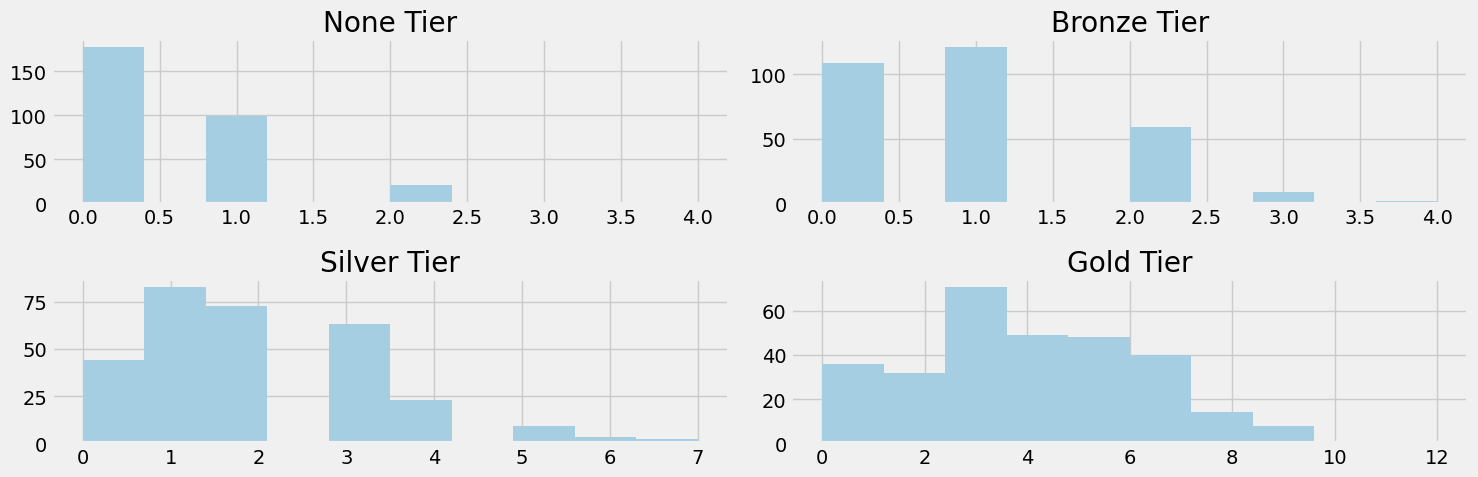

In [4]:
#| label: fig-dist-1
#| fig-cap: "Average # of items purchased per day segmented by customer loyalty status."

#View item purchase distribution for each tier
n = 300
fig, ax = plt.subplots(2,2, figsize=(15,5))

ax[0,0].hist(np.random.poisson(.5, n))
ax[0,0].set_title("None Tier")

ax[0,1].hist(np.random.poisson(1, n))
ax[0,1].set_title("Bronze Tier")

ax[1,0].hist(np.random.poisson(2, n))
ax[1,0].set_title("Silver Tier")

ax[1,1].hist(np.random.poisson(4, n))
ax[1,1].set_title("Gold Tier")

fig.tight_layout();

@fig-dist-1 shows that on average, our none tier customers don't purchase anything, bronze tier is around 1 item, silver tier around 2 items, and gold tier around 4. This is expected as we suppose that as loyalty increases so does amount purchased daily. 

In [5]:
#Generate synthetic data
df = get_syn_data(4000, 1, r_seed=42)

Within the experiment itself, we aimed to have 50% of customers be part of the control group with the other 50% in treatment split amongst the 9 treatmentes. The dataset below shows the splits in treatments.

In [6]:
#View distribution of treatments
df.groupby(['marketing_channel', 'marketing_treatment'])['user_id'].count()

marketing_channel  marketing_treatment
email              discount                222
                   free_donut              212
                   free_juice              225
in-app             discount                211
                   free_donut              208
                   free_juice              222
none               none                   2047
social             discount                213
                   free_donut              204
                   free_juice              236
Name: user_id, dtype: int64

The total observations in the dataset is 4000. Each treatment received around 200 customers and the control sat around 2000. 

To get a good idea on whether the treatments had an impact or not, we can look at @fig-bar-1. 

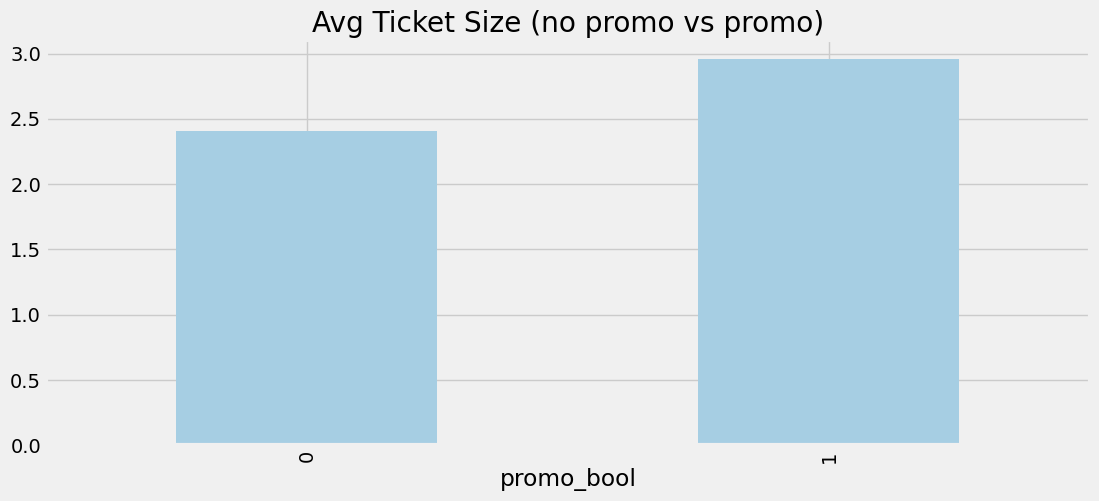

In [7]:
#| label: fig-bar-1
#| fig-cap: "Average ticket between control and treated customers."

#View avg ticket distribution of transactions w/ promo vs not
(df.assign(promo_bool = lambda x: np.where(x.marketing_treatment != 'none', 1, 0))
 .groupby('promo_bool')
 ['ticket_size']
 .mean()
 .plot(kind='bar', figsize=(12,5), title='Avg Ticket Size (no promo vs promo)')
);

@fig-bar-1 clearly shows an increase in the average ticket size of treated customers. While we don't know for sure if the difference is statistically significant, it is comforting to see that from the data, there is approximately a 50 cent difference. We can further view the effects of treatments by segmenting by tier and viewing the respective changes in ticket size based on the treatments received. This is shown in @fig-bar-2.

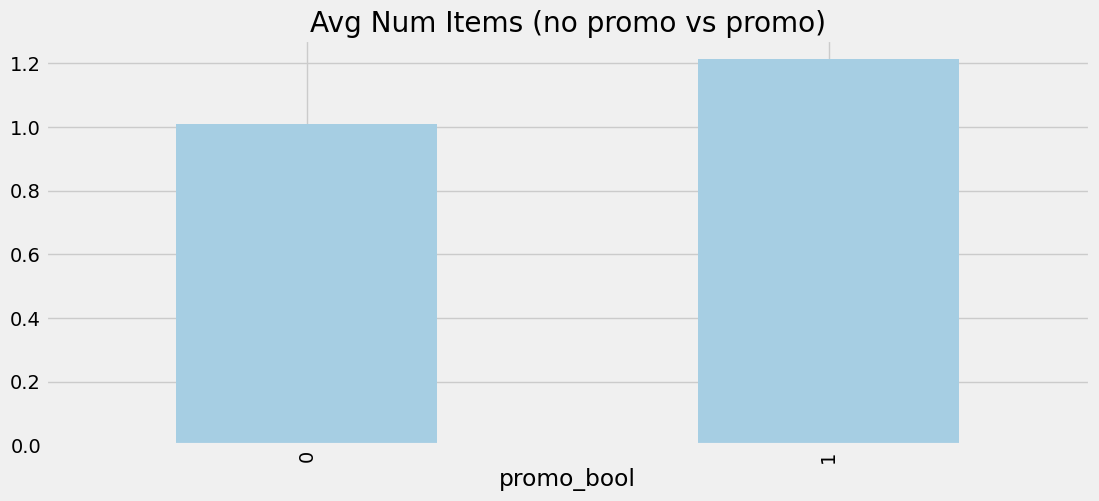

In [8]:
#| output: false

#View avg num items distribution w/ promo vs not
(df.assign(promo_bool = lambda x: np.where(x.marketing_treatment != 'none', 1, 0))
 .groupby('promo_bool')
 ['num_items_purchased']
 .mean()
 .plot(kind='bar', figsize=(12,5), title='Avg Num Items (no promo vs promo)')
);

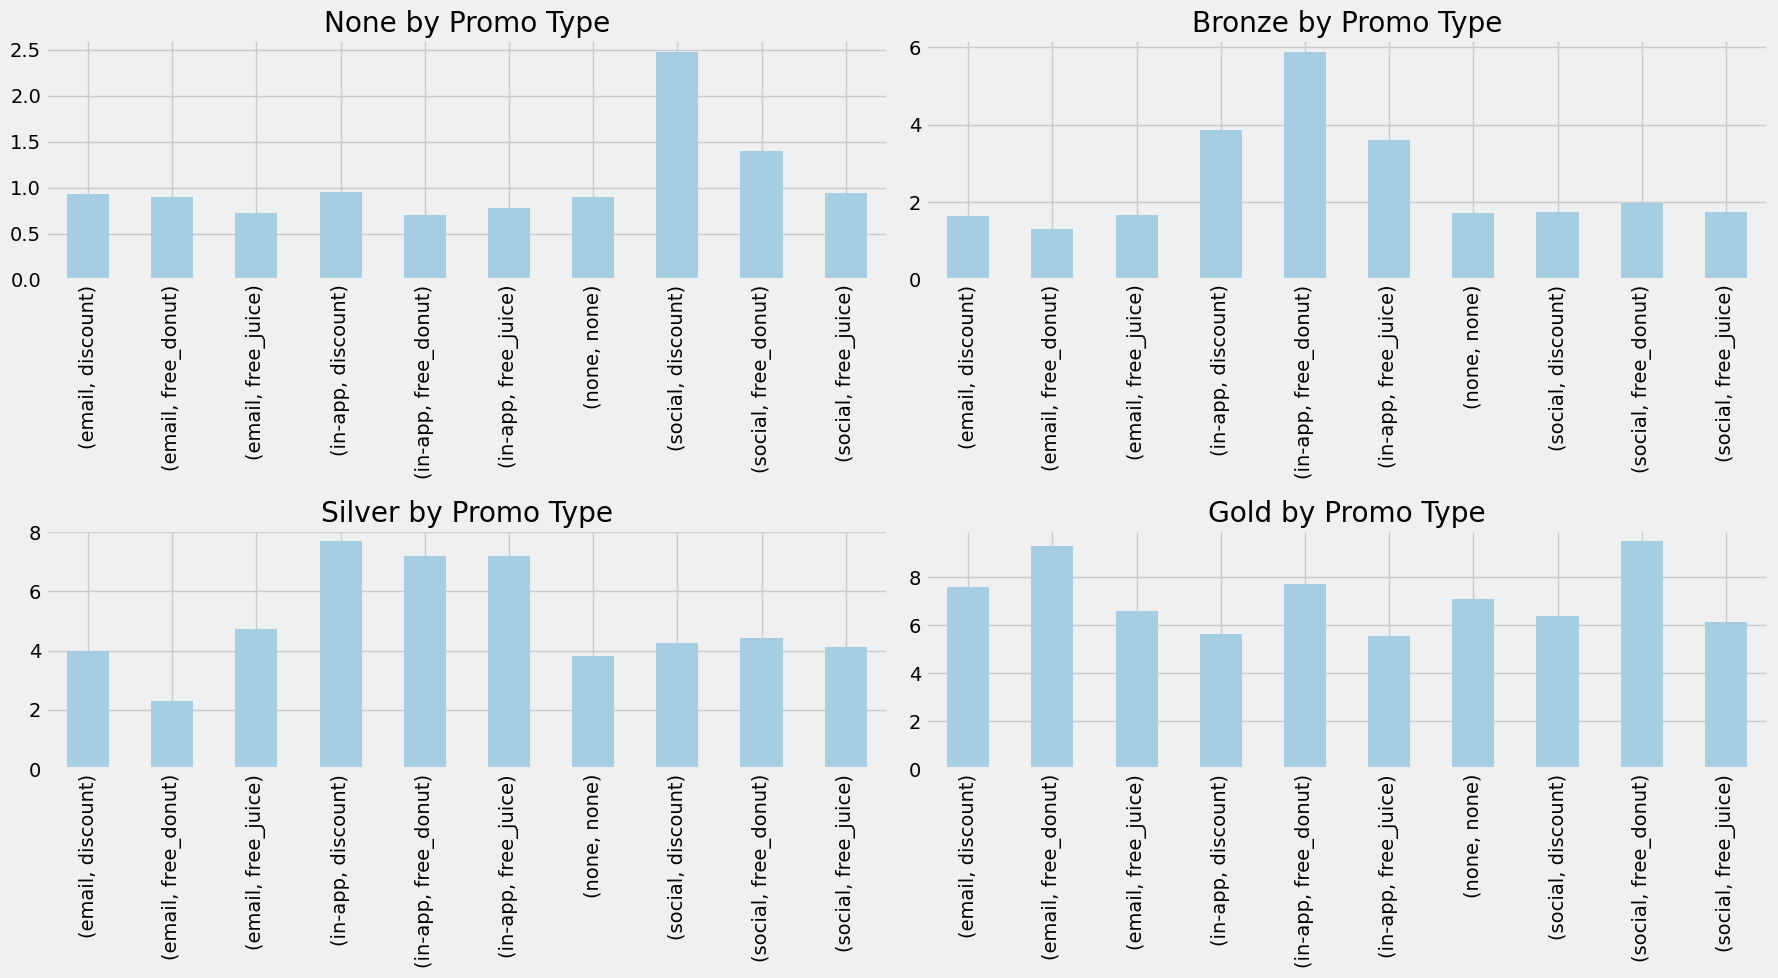

In [9]:
#| label: fig-bar-2
#| fig-cap: "Average ticket size for each treatment, broken down by customer loyalty tier."

#View avg ticket distribution of transactions by promo type and tier
fig, ax = plt.subplots(2,2, figsize=(18,10))

tier = ['none', 'bronze', 'silver', 'gold']
for i, a in enumerate(ax.flatten()):
    (df.query("loyalty_tier == @tier[@i]")
     .groupby(['marketing_channel', 'marketing_treatment'])
     ['ticket_size']
    .mean()
    .plot(kind='bar', ax=a, title=f"{tier[i].capitalize()} by Promo Type")
    )
    a.set_xlabel("")
    
    
fig.tight_layout();

@fig-bar-2 tells an even better story than @fig-bar-1. Here, we see that each loyalty tier had different responses to the treatments. The none tier customers had a huge spike in average ticket size when treated via social media with the 30% discount. Bronze tier customers seemed to favor the free donut the most via the app. Silver tier enjoyed any promotion via the app. Gold tier is a bit harder to identify due to the amount of variation in their data, but free donuts appear to be the most impactful for ticket size. 

While the increase in revenue is an important start in the uplift analysis, we need to remember we are optimizing for *Net Value*. Thus, we need to include the costs associated with sending these promotions. @fig-bar-3 shows this change.

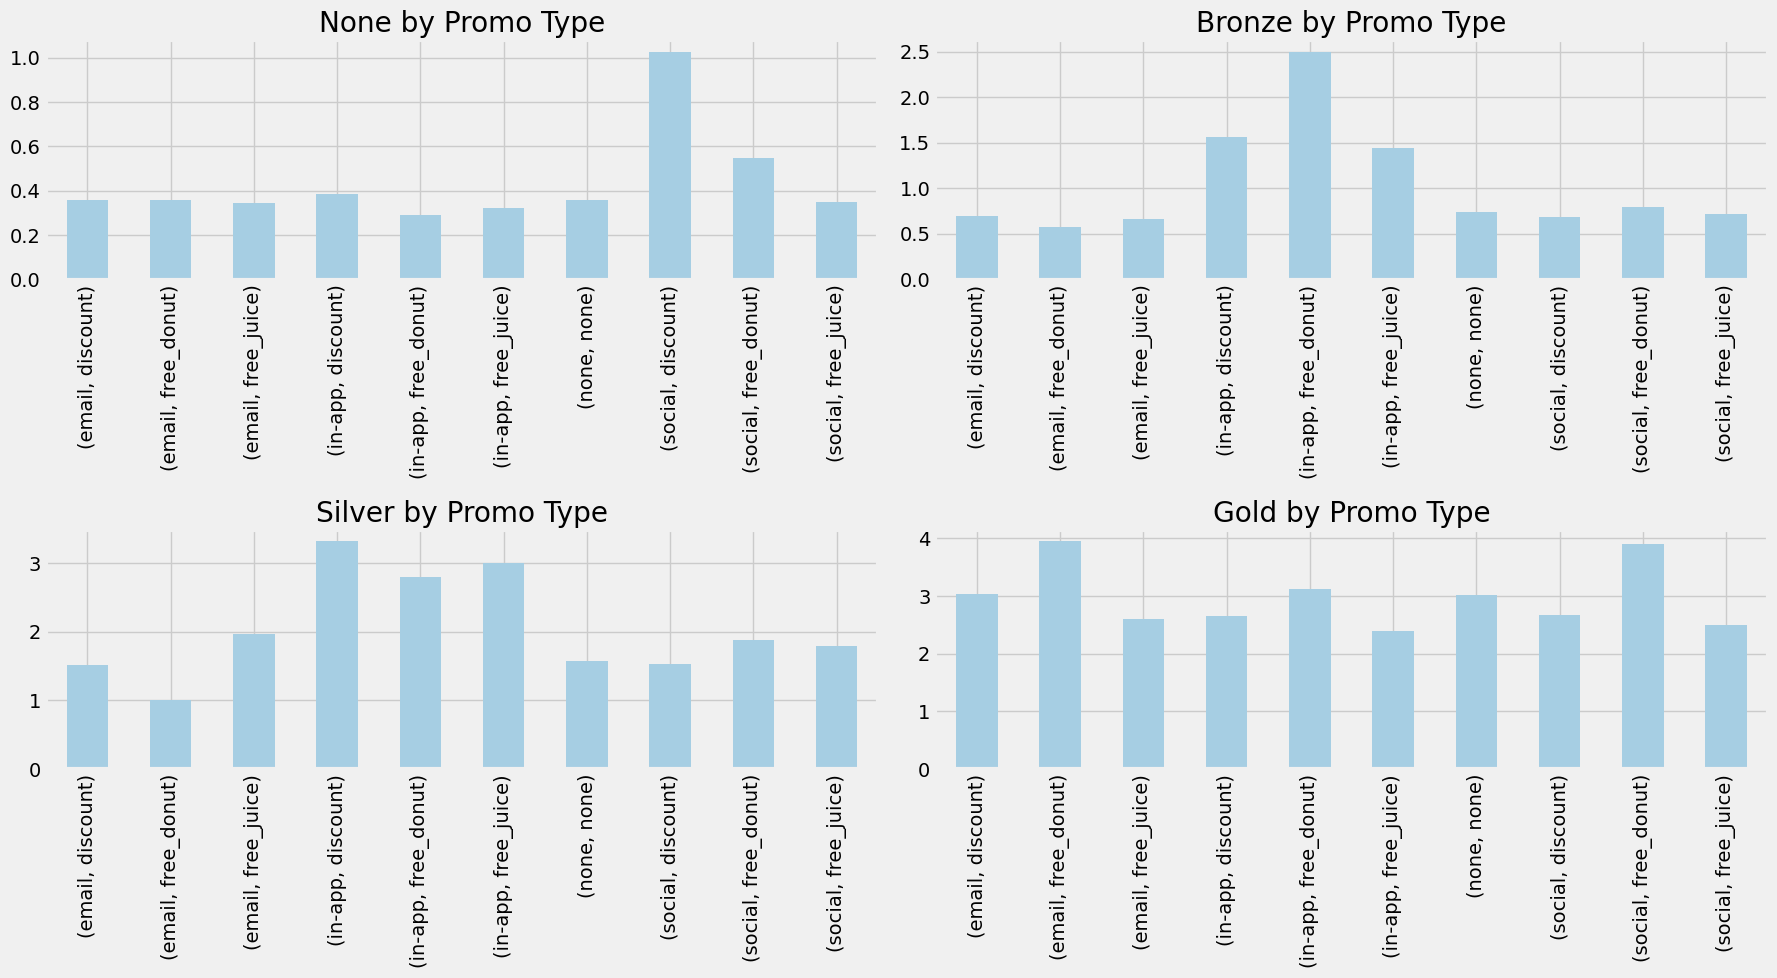

In [10]:
#| output: false

#View avg num items purchased distribution by promo type and tier
fig, ax = plt.subplots(2,2, figsize=(18,10))

tier = ['none', 'bronze', 'silver', 'gold']
for i, a in enumerate(ax.flatten()):
    (df.query("loyalty_tier == @tier[@i]")
     .groupby(['marketing_channel', 'marketing_treatment'])
     ['num_items_purchased']
    .mean()
    .plot(kind='bar', ax=a, title=f"{tier[i].capitalize()} by Promo Type")
    )
    a.set_xlabel("")
    
    
fig.tight_layout();

In [11]:
#Calculate simple net value
df = df.assign(net_val = lambda x: x.ticket_size - x.marketing_costs)

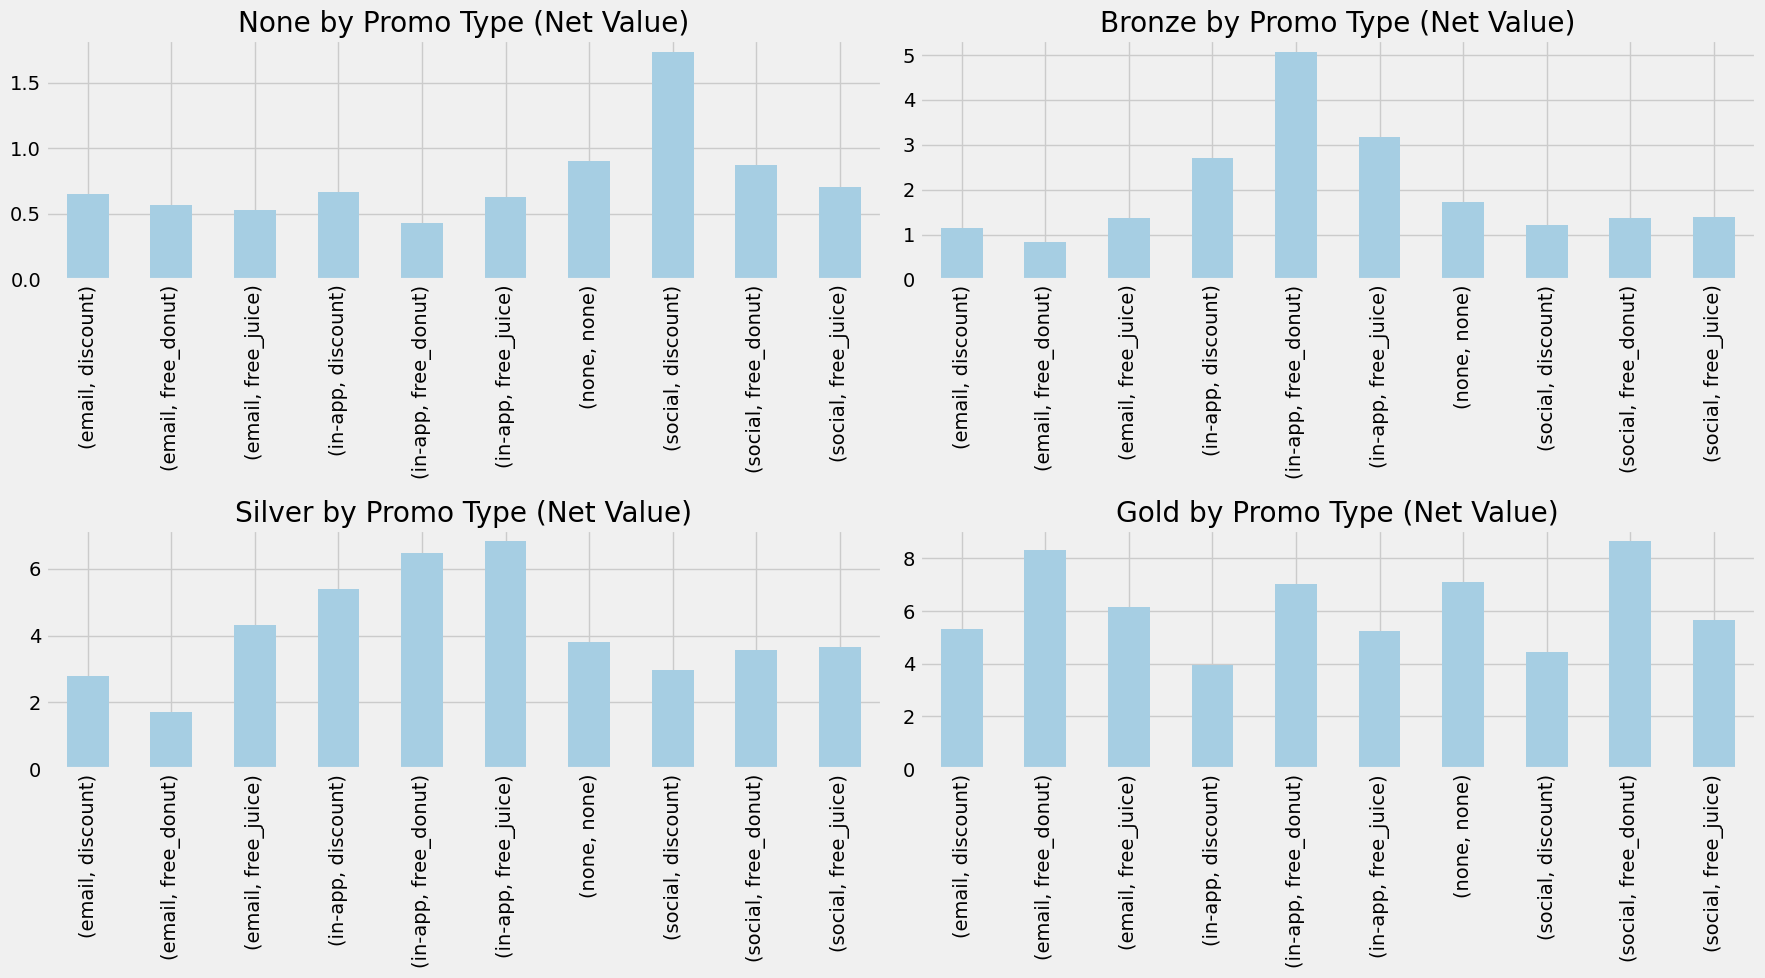

In [12]:
#| label: fig-bar-3
#| fig-cap: "Average net value for each treatment, broken down by customer loyalty tier."

#Plot Net Val by Promo Type
fig, ax = plt.subplots(2,2, figsize=(18,10))

tier = ['none', 'bronze', 'silver', 'gold']
for i, a in enumerate(ax.flatten()):
    (df.query("loyalty_tier == @tier[@i]")
     .groupby(['marketing_channel', 'marketing_treatment'])
     ['net_val']
    .mean()
    .plot(kind='bar', ax=a, title=f"{tier[i].capitalize()} by Promo Type (Net Value)")
    )
    a.set_xlabel("")
      
fig.tight_layout();

@fig-bar-3 shows how the costs of marketing affected each treatment, but especially the discount ones. A 30% discount is a hefty price to pay for our business so if we can avoid such a heavy cost by finding treatments that cost less but are just as effective, that would be great. The results appear to hold from @fig-bar-2.

# Uplift Modeling

As mentioned in the introduction, uplift modeling estimates *how* a customer will react to interventions. There are many ways to estimate the uplift of a treatment. In this section, we implement a x-learner [@Kunzel2017MetaLearners]. The x-learner belongs to a family of algorithms called *meta-learners* that specialize in utilizing machine learning approaches like random forests or boosting methods to estimate causal effects. While the x-learner was originally designed for binary treatments, [@zhao2019uplift] demonstrates a way to extend the framework to multiple treatments. The stages of implementing the x-learner are shown below.

$$
\mu_{t_{j}} = E[Y(t_{j})|X=x]
$${#eq-x-1}

$$
D^{t_{0}}_{i} = \hat{\mu}_{t_{j}}(x) - Y_{i}
$$
$$
D^{t_{j}}_{i} = Y_{i} - \hat{\mu}_{t_{0}}(x) 
$${#eq-x-2}

$$
\hat{\tau}^{t_{j}}(x) = \frac{\hat{e}_{t_{j}}(x)}{\hat{e}_{t_{j}}(x) + \hat{e}_{t_{0}}(x)}\hat{\tau}_{t_{0}}(x) + \frac{\hat{e}_{t_{0}}(x)}{\hat{e}_{t_{j}}(x) + \hat{e}_{t_{0}}(x)}\hat{\tau}_{t_{j}}(x)
$${#eq-x-3}

The first stage of the x-learner is just normal regression. We fit any regression type model to model the outcomes of $Y$ on covariates $X$ for each treatment $t$. The second stage of the x-learner is where we impute the treatment effect $D$ by using the fitted regression models from @eq-x-1. This is essentially calculating counterfactual outcomes such that we can estimate individual treatment effects (ITEs). This is once again done for each treatment $t$. We then "repeat" the process as before and create regression models that regress the treatment effects (or more properly, pseudo-effects) on the covariates $X$ to obtain functions $\hat{\tau}_{t_{0}}$ for the control and $\hat{\tau}_{t_{j}}$ for the j-th treatment. The third stage utilizes the propensity scores for each treatment to adjust the "weights" of each treatment. These weights adjust the outputs from the models generated from @eq-x-2 to obtain our CATE for each treatment $j$. 

To train our x-learner, we use the `causalML` library. We use an 80-20 split on 4000 observations (~2000 control vs ~2000 treated, split among 9 treatments). The base learner for our x-learner is a gradient boosting regressor from `sklearn`.

While understanding the CATE due to all features in the dataset, for this business case specifically, understanding the CATE for each tier is of great importance. An understanding of what promotion is most effective with each tier is crucical for marketing strategy optimization. Below we output the CATE values for those in the none tier.

In [13]:
#Prepare data for uplift modeling
t = (df.assign(treatment = lambda x: x.marketing_channel + "-" + x.marketing_treatment)
     ['treatment'])
X = (df.drop(['user_id', 'ticket_size', 'num_items_purchased', 'marketing_costs', 
              'marketing_channel', 'marketing_treatment', 'ticket_size', 'net_val'], axis=1)
     .pipe(lambda x: pd.get_dummies(x, columns=['loyalty_tier'])))
y = (df['net_val'])

In [14]:
#Perform train-test split
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, y, t, test_size=0.2, random_state=42)

In [15]:
#Create dictionary for map
t_map = {t.unique()[i]: np.full(len(X), .0625) for i in range(len(t.unique()))}
t_map['none-none'] = np.full(len(X), .5)

t_map_train = {t.unique()[i]: np.full(len(X_train), .055) for i in range(len(t.unique()))}
t_map_train['none-none'] = np.full(len(X_train), .5)

t_map_test = {t.unique()[i]: np.full(len(X_test), .055) for i in range(len(t.unique()))}
t_map_test['none-none'] = np.full(len(X_test), .5)

In [16]:
#Define x-learner model
learner_x = BaseXRegressor(learner=GradientBoostingRegressor(), 
                           control_name="none-none")

In [17]:
#Fit model
learner_x.fit(X_train, t_train, y_train, t_map_train)

In [18]:
#Get CATE
cate_preds = learner_x.predict(X_test, t_test, y_test, t_map_test)

In [19]:
#Get tier specific CATE
idx_tier = X_test.reset_index(drop=True).query("loyalty_tier_none == True").index

In [20]:
#Show CATE
cate_preds[idx_tier,:].mean(axis=0)

array([-0.50800717, -0.33919301, -0.48013309, -0.16522906, -0.2352354 ,
       -0.09895951,  1.14556021, -0.28385185, -0.26179227])

In [21]:
#Get class mappings
learner_x._classes

{'email-discount': 0,
 'email-free_donut': 1,
 'email-free_juice': 2,
 'in-app-discount': 3,
 'in-app-free_donut': 4,
 'in-app-free_juice': 5,
 'social-discount': 6,
 'social-free_donut': 7,
 'social-free_juice': 8}

Utilizing the mapping dictionary above, we see that most of our promotions on average perform no better (or actually worse) than the control, with the exception to one. The social discount promotion shows that it adds an additional 1.15 to our net value, on average. Due to the synthetic nature of our data, we are pleased with this result as the x-learner correctly identified the one promotion that we set to have an influence on purchasing behavior for those in the none loyalty tier. In a real business case, we'd want to further validate these estimates by doing a variety of checks (e.g. confidence intervals, AUUC, sensitivity checks, etc.). For the purpose of this post, it suffices us to see that the x-learner identified the hidden causal mechanism in the data. 

# Uplift Modeling with Non Compliance

For the purposes of business strategy in understanding which promotions worked best, our above approach and results would suffice. We identified with our x-learner which promotions cause a higher ticket size for different tiered customers. We can present these suggestions to our marketing team and away they go at promoting the business more effectively. However, from the lens of causal inference data scientists, we know these estimates are biased. Not everyone we sent our promotions to went to the store to make a purchase. This means that not everyone who was treated acted upon the treatment we provided. This suggests that we have *non compliance* within our study.

Non compliance gets its name from biostatistic experiments where researchers would assign treatments to individuals but those individuals would not comply with the directive. This is exactly what is happening in our study. Not everyone who was treated with a promotion went to the store to make a purchase. @fig-scat-1 shows exactly this problem.

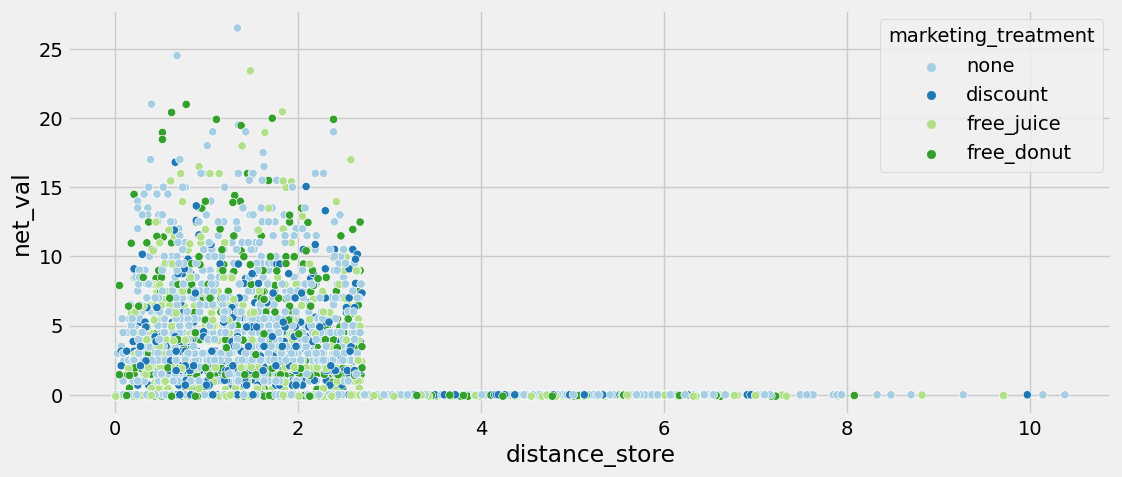

In [39]:
#| label: fig-scat-1
#| fig-cap: "Scatterplot of net value by distance to store colored by treatment."

#Show purchase distribution by distance
plt.figure(figsize=(12,5))
sns.scatterplot(x=df['distance_store'], y=df['net_val'], hue=df['marketing_treatment']);

We see that anyone who was more than 2.75 miles from the store did not make a purchase, regardless of treatment. However, we assumed in the beginning that those who were in the control could not receive promotional effects (i.e. control can't non comply). Therefore, we are only dealing with non complianace via treated -> control. From this perspective, while we did calculate a CATE, we did so estimating the intent to treat (ITT). This is the causal effect of treatment assignment, not of the treatment itself. To calculate the causal effect of the treatment, we need to accounnt for non compliance.

In order to account for non compliance within our study, we can utilize a popular approach of implementing an instrument variable (IV). IVs help reintroduce randomization into our study to help isolate the causal variation in our treatments. A IV needs to meet three assumptions. First, the IV must be correlated with the treatment (Relevance). Second, the IV must affect the outcome only through the treatment (Exclusion). Third, the IV must be independent of unmeasured confounders that affect the treatment and outcome (Exogeneity). In our case, we can simply add the instrument *Promotion Offered* to be our IV since it matches these assumptions. @fig-dag-2 illustrates our new flow of causality.

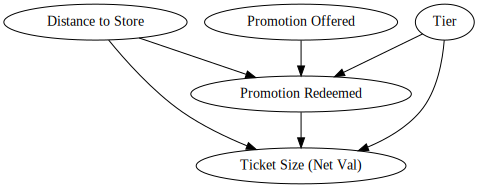

In [23]:
#| label: fig-dag-2
#| fig-cap: "Proposed DAG for addressing non compliance in our study."

#Redraw DAG
g = gr.Digraph()

g.edge("Promotion Offered", "Promotion Redeemed")
g.edge("Distance to Store", "Promotion Redeemed")
g.edge("Distance to Store", "Ticket Size (Net Val)")
g.edge("Tier", "Ticket Size (Net Val)")
g.edge("Tier", "Promotion Redeemed")
g.edge("Promotion Redeemed", "Ticket Size (Net Val)")

g

Our updated DAG in @fig-dag-2 shows how this new knowledge of non compliance affects how we model causality. Because we know that distance to store affects whether or not a customer goes to the store, it now has causal edges to promotion redeemed and ticket size. Additionally, from our EDA we noticed that different tiers purchase at different rates so tier still affects ticket size directly. As well, different tiers value different promotions so it has an effect on whether the promotion is redeemed or not. Lastly, we included our IV in promotion offered. Promotion offered is not affected by other confounders, only affects the outcome of net value through promotion redeemed, and is clearly correlated with promotion redeemed.  

To model our new approach, we utilize *causal IV forests* from [@wager2015estimation]. Causal forests build off the foundations of random forests. It utilizes n number of decision trees to calculate the average result. The causality comes from estimating the counterfactual outcomes, just as we saw with the x-learner above. To perform this, the splitting criterion focuses on the variation in treatment effect. A short summary of the algorithm is provided below. 

1. For a given tree, randomly sample data with replacement and split into split and estimation set.
2. For a given node in a tree, iterate through features and cut points.
3. Identify the split that maximizes the variance-based criterion such that heterogeneity is maximized.
4. For a fully grown tree, for each terminal node, estimate CATE.
5. Average CATE across all trees.

For a more thorough explanation of the algorithm, see [@wager2015estimation]. The algorithm is then adapted to our scenario where we utilize IVs. In this case, the algorithm becomes generalized to incorporate $Z$, our indicator variable of whether or not a customer was assigned a promotion or not. The algorithm then adjusts for this by estimating the local conditional average treatment effect (L-CATE).

Our causalIVforest is implemented using `econML`. Similar to above, we use a 80-20 split. We do not perform any hyperparameter tuning for the causalIVforest. We output the split of tiers in our test set below.

In [24]:
#Create instrument variable dataset
inst_df = (df.assign(offer_treat = lambda x: x.marketing_channel + '-' + x.marketing_treatment)
 .pipe(lambda x: pd.get_dummies(x, columns=['offer_treat', 'loyalty_tier']))
 .pipe(lambda x: x.assign(** {f"redeem_offer_{promo.removeprefix('offer_treat_')}": 
                              np.where((x[promo] == True) & (x["num_items_purchased"] > 0), True, False) 
                              for promo in x.filter(like='offer_treat_').columns})
      
      )
 .drop(['redeem_offer_none-none', 'offer_treat_none-none', 
        'user_id', 'marketing_channel',
        'marketing_treatment', 'marketing_costs',
        'ticket_size', 'num_items_purchased'], axis=1)
 #.pipe(lambda x: x.assign(** {f"{promo}_x_{tier}": x[promo] * x[tier] 
 #                             for promo in x.filter(like='redeem_offer_').columns for tier in x.filter(like='loyalty_tier_').columns}))
 #.pipe(lambda x: x.assign(** {f"{promo}_x_{tier}": x[promo] * x[tier] 
 #                             for promo in x.filter(like='offer_treat_').columns for tier in x.filter(items=['loyalty_tier_bronze', 'loyalty_tier_silver', 'loyalty_tier_gold']).columns}))
)


In [29]:
#Perform train-test split
X = inst_df[['age', 'distance_store', 'loyalty_tier_none', 'loyalty_tier_bronze', 'loyalty_tier_silver', 'loyalty_tier_gold']]
y = inst_df['net_val']
T = inst_df.filter(like='redeem_offer_')
Z = inst_df.filter(like='offer_treat_')

X_train, X_test, y_train, y_test, T_train, T_test, Z_train, Z_test = train_test_split(X, y, T, Z, test_size=0.2, random_state=42)

In [30]:
#Instantiate CausalIVForest
mod_civ = CausalIVForest(random_state=42)

In [31]:
#| output: false

#Fit CausalIVForest
mod_civ.fit(X=X_train, T=T_train, y=y_train, Z=Z_train)

CausalIVForest(random_state=42)

In [32]:
#Get counts of tiers from test set
tier_lst = ['loyalty_tier_none', 'loyalty_tier_bronze', 'loyalty_tier_silver', 'loyalty_tier_gold']
X_test[tier_lst].sum()

loyalty_tier_none      309
loyalty_tier_bronze    264
loyalty_tier_silver    161
loyalty_tier_gold       66
dtype: int64

After fitting our data, we test the model on the above sample and yield the following results shown in @fig-bar-4. We also output the explicit effects for each treatment in the none loyalty tier below.

In [33]:
#Get HTEs
civ_preds = mod_civ.predict(X_test)

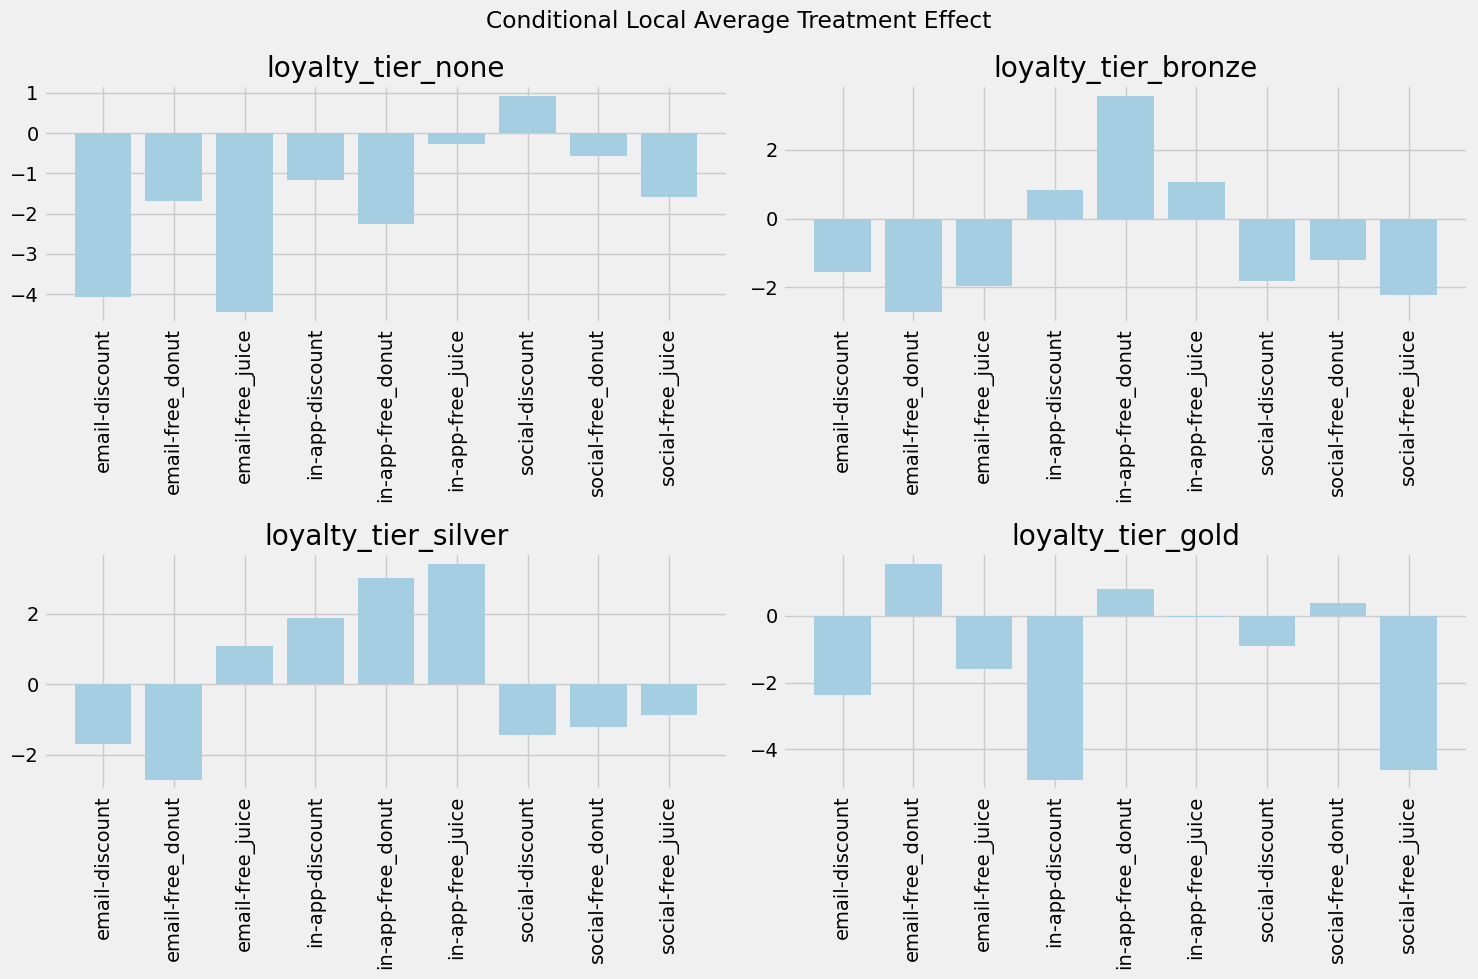

In [34]:
#| label: fig-bar-4
#| fig-cap: "C-LATE for each tier, treatment combination."

#Get HTE for each tier
fig, ax = plt.subplots(2,2, figsize=(15,10))

for i, a in enumerate(ax.flatten()):
    tier_idx = X_test.reset_index(drop=True).query(f"{tier_lst[i]} == True").index
    a.bar(T.columns.str.removeprefix("redeem_offer_"), civ_preds[tier_idx].mean(axis=0))
    a.set_title(f"{tier_lst[i]}")
    a.tick_params(axis='x', rotation=90)

fig.suptitle("Conditional Local Average Treatment Effect")
fig.tight_layout();

In [35]:
#Show explicit effects
tier_idx = X_test.reset_index(drop=True).query(f"{tier_lst[0]} == True").index
civ_preds[tier_idx].mean(axis=0)

array([-4.0571709 , -1.68161069, -4.44325053, -1.15262721, -2.26189429,
       -0.27730894,  0.92089754, -0.57709819, -1.58279785])

@fig-bar-4 looks very similar to @fig-bar-3, but with an important distinction. @fig-bar-3 were the average net values in the raw data. @fig-bar-4 shows the treatment effects for each treatment for each tier. Looking at the none tier graph and numeric output, we see that all treatments yield a negative treatment effect with the exception to social-discount. This makes sense since from our synthetic data, none of the other treatments should have yieled a change in consumer behavior. Thus, when accounting for the costs of marketing, these other treatments cause a negative effect in net value. Conversely, since social-discount yields a +1 increase to purchase behavior, it shows a positive increase in net value. This pattern continues throughout all the tiers. 

The important distinction to make from this output and that of the x-learner is what the story behind each metric is. For the x-learner, we estimated the conditional intent to treat (CITT) effect, showing how *assignment* of the treatment causes changes in customer behavior. For the causalIVforest, we estimated the conditional local average treatment effect (C-LATE), showing how the *redemption* of the promotion causes changes in customer behavior. One estimates with everyone regardless of if they redeemed or not and the other estimates only for those who would redeem.

# Conclusion

In this post, we posed a business problem of understanding the effects of our promotions on customer purchase behavior. We demonstrated two causal inference methods using machine learning: the x-learner and the causalIVforest. The x-learner was used to estimate CATE/CITT so that our business could understand the effects of assignment of promotion on our customers, specifically the different loyalty tiers. The causalIVforest was used to estimate C-LATE so that our business could more precisely understand the effects of redemption of promotion in customer behavior. Overall, we hope that this post was a good demonstration on the usefulness of causal inference in business situations and how one can utilize Python packages to carry out an informative analysis.